In [176]:
import numpy as np
from matplotlib import pyplot as plt
import functions as ut
from tqdm.auto import tqdm

In [177]:
# Number of data points
N = 10000
# Number of classes
K = 10
# Number of dimensions
D = 3072

In [178]:
# Exercise 1 part 1
def onehotencoding(labels):
    """
    One-hot encodes the given labels.
    
    Args:
        labels (np.array): The labels to be one-hot encoded.
        
    Returns:
        np.array: The one-hot encoded labels.
    """
    
    hot = np.zeros((K, N))
    for i in range(N):
        hot[labels[i]][i] = 1
    return hot

def load(fname):
    """
    Load the data from the given filename.
    
    Args:
        fname (str): The path to the file containing the data.
        
    Returns:
        dict: A dictionary containing the loaded data with the following keys:
            - "labels": The labels of the data.
            - "hot": The one-hot encoded labels.
            - "data": The data itself.
    """

    batch = ut.LoadBatch(fname)
    out = {}
    out["labels"] = batch[b"labels"]
    out["data"] = batch[b"data"].T.astype(float)
    out["hot"] = onehotencoding(out["labels"]) 
    
    return out

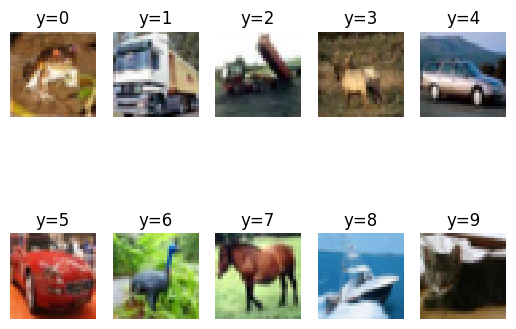

In [179]:
# Load all data sets and view sample images

train = load("data_batch_1")
val = load("data_batch_2")
test = load("test_batch")

ut.montage(train["data"].T)

In [180]:
def transform(dataset):
    """
    Transforms the given dataset by normalizing the data.
    """
    data = dataset["data"]
    meanX = np.mean(data, axis=0)
    stdX = np.std(data, axis=0)
    dataset["data"] = (data - meanX) / stdX


In [181]:
transform(train)
transform(val)
transform(test)

In [182]:
# Exercise 1 part 3

# Weights and biases
W = np.random.normal(0,0.1,size=(K,D))
b = np.random.normal(0,0.1,size=(K,1))

In [183]:
# Exercise 1 part 4

def evaluateClassifier(X, W, b):
    """
    Evaluate the classifier for a given input.
    
    Args:
        X (numpy.ndarray): Input data of shape (d, N), where d is the number of features and N is the number of samples.
        W (numpy.ndarray): Weight matrix of shape (K, d), where K is the number of classes.
        b (numpy.ndarray): Bias vector of shape (K, 1), where K is the number of classes.
        
    Returns:
        numpy.ndarray: Softmax probabilities of shape (K, N), where K is the number of classes and N is the number of samples.
    """
    s = W @ X + b
    return ut.softmax(s)

In [184]:
# Exercise 1 part 5

def lcross(x, y, W, b):
    """
    Calculates the cross-entropy loss for a single example.

    Args:
        x (numpy.ndarray): Input data of shape (d, N).
        y (numpy.ndarray): One-hot encoded true label of shape (K, N).
        W (numpy.ndarray): Weight matrix of shape (K, d).
        b (numpy.ndarray): Bias vector of shape (K, 1).

    Returns:
        float: Cross-entropy loss.
    """
    P = evaluateClassifier(x, W, b)
    return - y * np.log(P)


def computeCost(X, Y, W, b, lmda):
    """
    Compute the cost function for linear regression with regularization.

    Args:
        X (numpy.ndarray): Input data of shape (d, N).
        Y (numpy.ndarray): One-hot encoded true label of shape (K, N).
        W (numpy.ndarray): Weight matrix of shape (K, d).
        b (numpy.ndarray): Bias vector of shape (K, 1).
        lmda (float): Regularization parameter.

    Returns:
    float: The computed cost.

    """
    reg_term = lmda * np.sum(W ** 2)

    loss_cross = lcross(X, Y, W, b)

    return 1 / X.shape[1] * np.sum(loss_cross) + reg_term
    


In [185]:
# Exercise 1 part 6

def computeAcc(X, Y, W, b):
    """
    Compute the accuracy of the classifier.

    Args:
        X (numpy.ndarray): Input data of shape (d, N).
        Y (numpy.ndarray): One-hot encoded true label of shape (K, N).
        W (numpy.ndarray): Weight matrix of shape (K, d).
        b (numpy.ndarray): Bias vector of shape (K, 1).

    Returns:
        float: Accuracy of the classifier.

    """
    P = evaluateClassifier(X, W, b)
    pred = np.argmax(P, axis=0)
    return np.mean(pred == Y)
    

In [186]:
def computeGrads(X, Y, W, b, lmbd):
    """
    Compute the gradients of the cost function with respect to the parameters.

    Args:
        X (numpy.ndarray): Input data of shape (d, N).
        Y (numpy.ndarray): One-hot encoded true label of shape (K, N).
        W (numpy.ndarray): Weight matrix of shape (K, d).
        b (numpy.ndarray): Bias vector of shape (K, 1).
        lmbd (float): Regularization parameter.

    Returns:
        list: A list containing the gradients of the cost function with respect to the weight matrix W and the bias vector b.
    """
    
    P = evaluateClassifier(X,W,b)
    G = P - Y
    gradB = 1 / X.shape[1] * np.sum(G, axis = 1)
    
    gradW = 1 / X.shape[1] * G @ X.T + 2*lmbd*W

    return [gradW, gradB.reshape(K,1)]

In [187]:
def ComputeGradsNumSlow(X, Y, W, b, lmbd, h):
	""" Converted from matlab code """
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape)
	grad_b = np.zeros((no, 1))
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] -= h
		c1 = computeCost(X, Y, W, b_try, lmbd)

		b_try = np.array(b)
		b_try[i] += h
		c2 = computeCost(X, Y, W, b_try, lmbd)

		grad_b[i] = (c2-c1) / (2*h)

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] -= h
			c1 = computeCost(X, Y, W_try, b, lmbd)

			W_try = np.array(W)
			W_try[i,j] += h
			c2 = computeCost(X, Y, W_try, b, lmbd)

			grad_W[i,j] = (c2-c1) / (2*h)

	return [grad_W, grad_b.reshape(K,1)]

In [188]:
def relerr(ga, gn, eps=1e-6):
    """
    Calculates the relative error between two vectors.

    Args:
        ga (numpy.ndarray): Analytical gradient.
        gn (numpy.ndarray): Numerical gradient.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The relative error between ga and gn.
    """
    
    diff = np.linalg.norm(ga - gn)
    norma = np.linalg.norm(ga)
    normn = np.linalg.norm(gn)
    numer = max(eps, norma + normn)
    return diff / numer

In [189]:
gaw, gab = computeGrads(train["data"][:,:20], train["hot"][:,:20], W, b, 0.3)
gnw, bnb = ComputeGradsNumSlow(train["data"][:,:20], train["hot"][:,:20], W, b, 0.3, 1e-6)
relerr(gaw, gnw)

2.1716033408684213e-08

In [190]:
def miniBatchGD(train, W, b, lmbd=0.1, n_batch=100, eta=0.001, n_epochs=20, val=None):
    """
    Perform mini-batch gradient descent.

    Args:
        X (numpy.ndarray): Input data of shape (d, N).
        Y (numpy.ndarray): One-hot encoded true label of shape (K, N).
        W (numpy.ndarray): Weight matrix of shape (K, d).
        b (numpy.ndarray): Bias vector of shape (K, 1).
        lmbd (float, optional): Regularization parameter. Defaults to 0.1.
        n_batch (int, optional): Number of mini-batches. Defaults to 100.
        eta (float, optional): Learning rate. Defaults to 0.001.
        n_epochs (int, optional): Number of epochs. Defaults to 20.

    Returns:
        tuple: A tuple containing the weight matrix W and the bias vector b.
    """
    X = train["data"]
    Y = train["hot"]

    costs = {"train" : [], "val" : []}
    accs = {"train" : [], "val" : []}
    
    for epoch in tqdm(range(n_epochs)):
        permutation = np.random.permutation(X.shape[1])
        X = X[:, permutation]
        Y = Y[:, permutation]

        for j in range(int(X.shape[1] / n_batch)):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            X_batch = X[:, j_start:j_end]
            Y_batch = Y[:, j_start:j_end]
            gradW, gradB = computeGrads(X_batch, Y_batch, W, b, lmbd)
            W -= eta * gradW
            b -= eta * gradB
        costs["train"].append(computeCost(X, Y, W, b, lmbd))
        accs["train"].append(computeAcc(X, Y, W, b))
        if val:
            costs["val"].append(computeCost(val["data"], val["hot"], W, b, lmbd))
            accs["val"].append(computeAcc(val["data"], val["hot"], W, b))
    return W, b, costs, accs

In [191]:
Wn, bn, costs, accs = miniBatchGD(train, W, b, lmbd=1.5, n_batch=100, eta=0.01, n_epochs=40, val=val)

  0%|          | 0/40 [00:00<?, ?it/s]

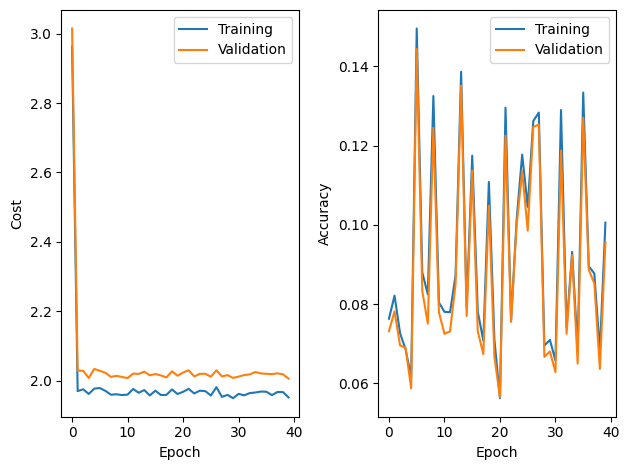

In [192]:
plt.subplot(1, 2, 1)
plt.plot(costs["train"], label="Training")
plt.plot(costs["val"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accs["train"], label="Training")
plt.plot(accs["val"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [193]:
computeAcc(test["data"], test["hot"], Wn, bn)

0.09744

In [194]:
def genWeightImage(slice):
    """
    Generates an image from the given slice of the weight matrix.
    
    Args:
        slice (numpy.ndarray): The slice of the weight matrix.
        
    Returns:
        numpy.ndarray: The generated image.
    """
    
    img = slice.reshape(32, 32, 3, order="F")
    img = img - np.min(img)
    img = img / np.max(img)
    return img

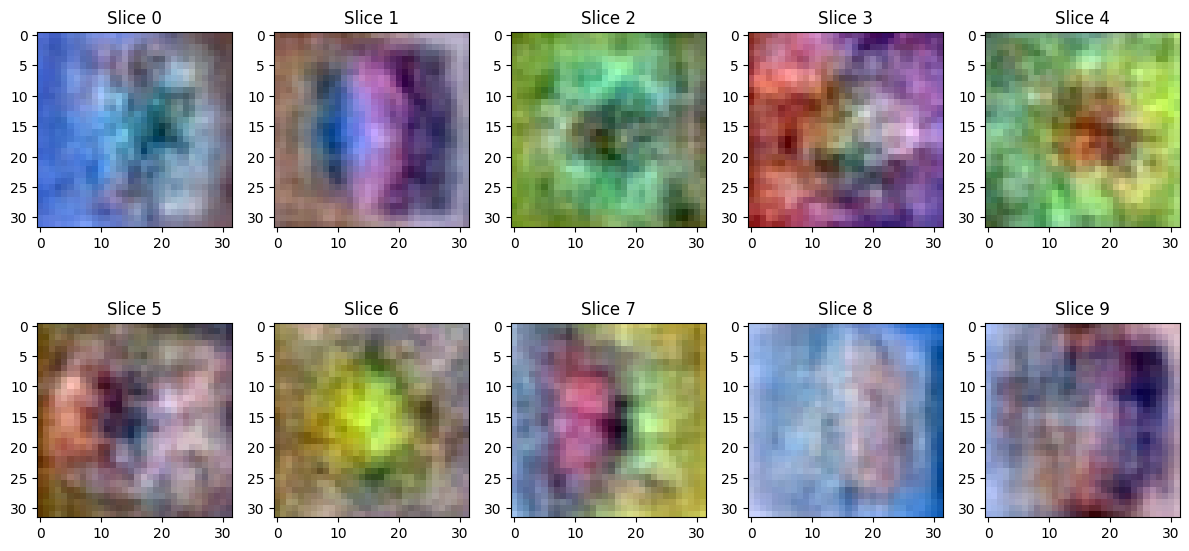

In [196]:

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(genWeightImage(Wn[i, :]))
    plt.title(f"Slice {i}")

plt.tight_layout()
plt.show()
